# 1. Read the dataset

In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")
  
training_data = pd.read_csv('data/training.csv')
test_data = pd.read_csv('data/test_features.csv')

print('The shape of the training dataset is:', training_data.shape)
print('The shape of the test dataset is:', test_data.shape)

The shape of the training dataset is: (71538, 13)
The shape of the test dataset is: (23846, 12)


# 2. Train a model 
* Exploratory Data Analysis
* Data Processing
* Model training

## 2.1 EDA

In [3]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71538 entries, 0 to 71537
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Pet ID                71538 non-null  object
 1   Outcome Type          71533 non-null  object
 2   Sex upon Outcome      71537 non-null  object
 3   Name                  44360 non-null  object
 4   Found Location        71538 non-null  object
 5   Intake Type           71538 non-null  object
 6   Intake Condition      71538 non-null  object
 7   Pet Type              71538 non-null  object
 8   Sex upon Intake       71537 non-null  object
 9   Breed                 71538 non-null  object
 10  Color                 71538 non-null  object
 11  Age upon Intake Days  71538 non-null  int64 
 12  Time at Center        71538 non-null  int64 
dtypes: int64(2), object(11)
memory usage: 7.1+ MB


In [4]:
training_data.describe()

,Age upon Intake Days,Time at Center
count,71538.000000,71538.000000
mean,702.701487,0.087003
std,1051.158334,0.281841
min,0.000000,0.000000
25%,30.000000,0.000000
50%,365.000000,0.000000
75%,730.000000,0.000000
max,9125.000000,1.000000


### 2.1.1 Univariate Statistics 

#### Plot a bar chart for the target variable

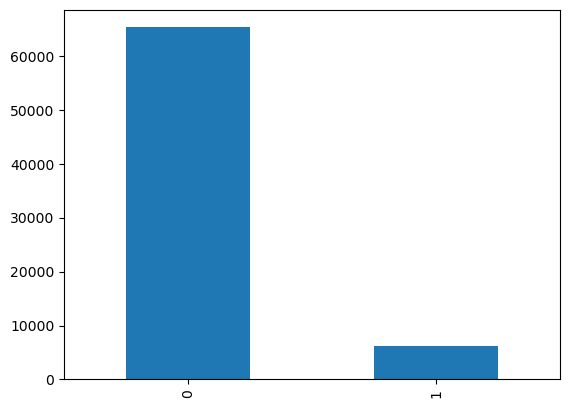

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
training_data['Time at Center'].value_counts().plot.bar()
plt.show()

#### Plot a bar chart for each categorical vairables

In [6]:
cat = training_data.select_dtypes(include = 'object').columns
cat

Index(['Pet ID', 'Outcome Type', 'Sex upon Outcome', 'Name', 'Found Location',
       'Intake Type', 'Intake Condition', 'Pet Type', 'Sex upon Intake',
       'Breed', 'Color'],
      dtype='object')

Outcome Type


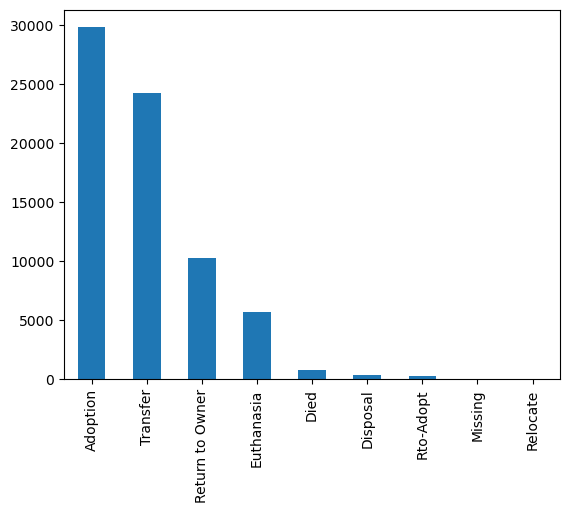

Sex upon Outcome


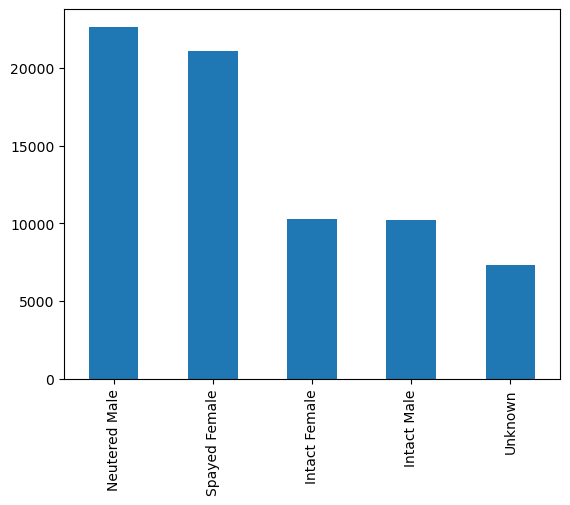

Intake Type


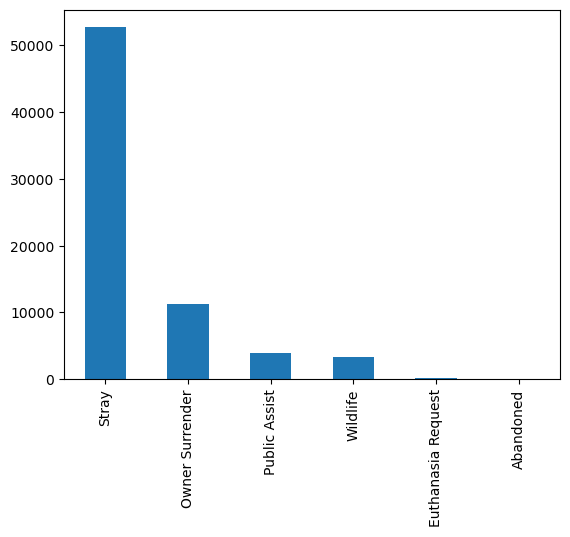

Intake Condition


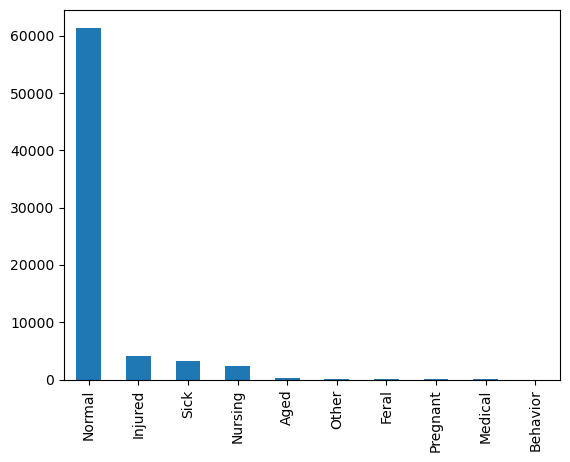

Pet Type


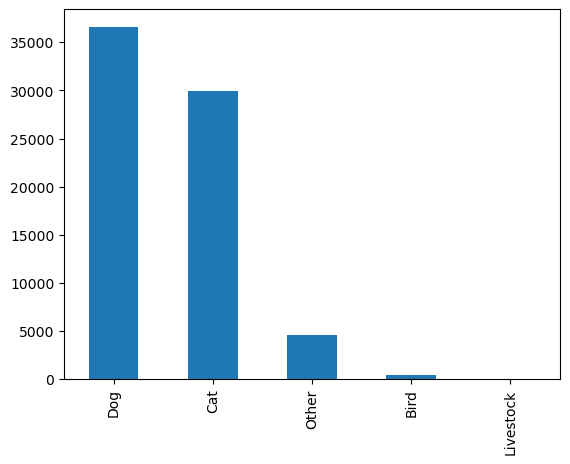

Sex upon Intake


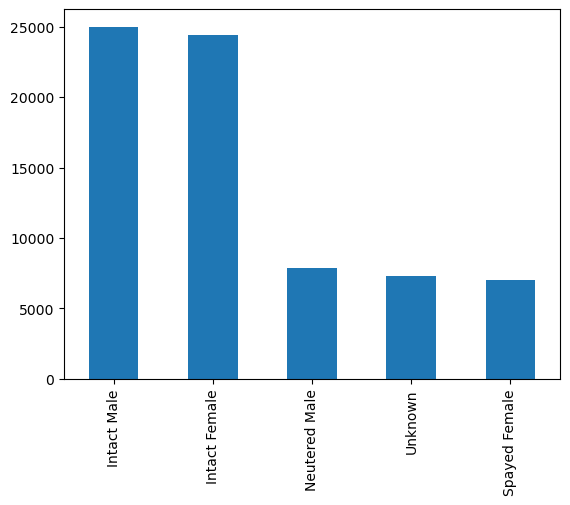

In [8]:
for c in cat: 
    if len(training_data[c].value_counts()) < 50:
        training_data[c].value_counts().plot.bar()
        print(c)
        plt.show()

#### Plot histogram for numerical feature 

In [12]:
num = training_data.drop('Time at Center', axis=1).select_dtypes(include = np.number).columns
num

Index(['Age upon Intake Days'], dtype='object')

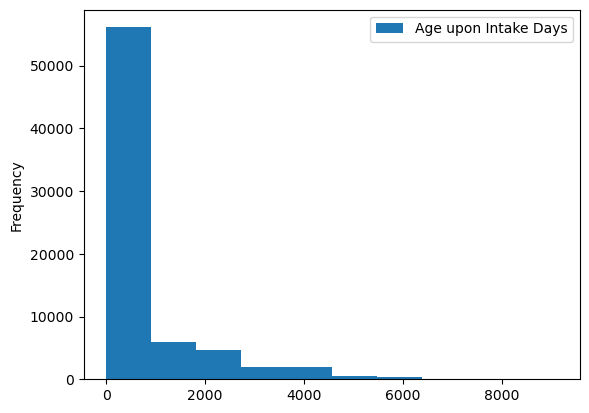

In [13]:
training_data[num].plot.hist(bins = 10)
plt.show()

### 2.2 Data Processing

#### 2.2.1 Find out outliers 

In [14]:
Q1 = training_data[num].quantile(0.25)
Q3 = training_data[num].quantile(0.75)
IQR = Q3 - Q1 
print(Q1, Q3, IQR)

Age upon Intake Days    30.0
Name: 0.25, dtype: float64 Age upon Intake Days    730.0
Name: 0.75, dtype: float64 Age upon Intake Days    700.0
dtype: float64


In [19]:
dropIndex = training_data[training_data[num] > Q3 + 1.5*IQR][num].dropna().index
train_data = training_data.drop(dropIndex)

In [20]:
train_data.shape

(61990, 13)

In [30]:
#no need to filter for Q1 - 1.5*IQR since the number is negative
print(Q1 - 1.5*IQR)

Age upon Intake Days   -1020.0
dtype: float64


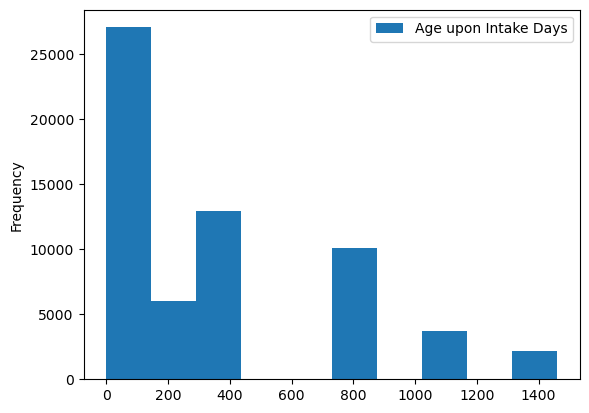

In [31]:
train_data[num].plot.hist(bins = 10)
plt.show()

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

#### 2.2.2 Create a classifier using a pipeline

In [37]:
classifier = Pipeline([
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('sclaer', MinMaxScaler()),
    ('estimator', KNeighborsClassifier(n_neighbors = 3))]
)

from sklearn import set_config
set_config(display = 'diagram')
classifier

Pipeline(steps=[('imputer', SimpleImputer()), ('sclaer', MinMaxScaler()),
                ('estimator', KNeighborsClassifier(n_neighbors=3))])

In [44]:
X_train = train_data[num]
Y_train = train_data['Time at Center']
print(X_train.shape, Y_train.shape)

(61990, 1) (61990,)


### 2.3. Fit the model on training data

In [45]:
classifier.fit(X_train, Y_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('sclaer', MinMaxScaler()),
                ('estimator', KNeighborsClassifier(n_neighbors=3))])

#### 2.3.1  Evaluate the trained model's performance on train dataset

In [46]:
train_predictions = classifier.predict(X_train)
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
print("Accuracy Score is", accuracy_score(Y_train, train_predictions))
print("F1 Score is", f1_score(Y_train, train_predictions))
print("Confusion Matrix")
confusion_matrix(Y_train, train_predictions)


Accuracy Score is 0.8869495079851589
F1 Score is 0.37839276210750394
Confusion Matrix


array([[52849,  3496],
       [ 3512,  2133]])

### 2.3.2 Predict outcome using test dataset

In [48]:
test_data.head()

,Pet ID,Outcome Type,Sex upon Outcome,Name,Found Location,Intake Type,Intake Condition,Pet Type,Sex upon Intake,Breed,Color,Age upon Intake Days
0,A782657,Adoption,Spayed Female,NaN,1911 Dear Run Drive in Austin (TX),Stray,Normal,Dog,Intact Female,Labrador Retriever Mix,Black,60
1,A804622,Adoption,Neutered Male,NaN,702 Grand Canyon in Austin (TX),Stray,Normal,Dog,Intact Male,Boxer/Anatol Shepherd,Brown/Tricolor,60
2,A786693,Return to Owner,Neutered Male,Zeus,Austin (TX),Public Assist,Normal,Dog,Neutered Male,Australian Cattle Dog/Pit Bull,Black/White,3285
3,A693330,Adoption,Spayed Female,Hope,Levander Loop & Airport Blvd in Austin (TX),Stray,Normal,Dog,Intact Female,Miniature Poodle,Gray,1825
4,A812431,Adoption,Neutered Male,NaN,Austin (TX),Owner Surrender,Injured,Cat,Intact Male,Domestic Shorthair,Blue/White,210


In [59]:
X_test = test_data[num]
test_predictions = classifier.predict(X_test)

In [58]:
type(test_predictions)

numpy.ndarray

In [60]:
test_predictions

array([0, 0, 0, ..., 0, 0, 0])

In [62]:
output = pd.concat([test_data[['Pet ID','Age upon Intake Days']], pd.DataFrame(test_predictions, columns = ['label'])], axis = 1)
output.head()

,Pet ID,Age upon Intake Days,label
0,A782657,60,0
1,A804622,60,0
2,A786693,3285,0
3,A693330,1825,0
4,A812431,210,0


In [63]:
output.to_csv('data/test_data_predict.csv', index = False)